
### TODO

- Visuals to decide which Scalar to use
- Data epxoeration to decide which Model use, or what to tune

# Home load approval prediction
## 1. Problem Defintion
predicting home load approvals

## 2. Data
Train: https://raw.githubusercontent.com/tseth4/loan-approval-capstone/refs/heads/main/loan_sanction_train.csv
Test: https://raw.githubusercontent.com/tseth4/loan-approval-capstone/refs/heads/main/loan_sanction_test.csv
## 3. Evaluation
## 4. Features


In [285]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC


# we want our plots to appear inside the notebook
%matplotlib inline


In [286]:
url = "https://raw.githubusercontent.com/tseth4/loan-approval-capstone/refs/heads/main/loan_sanction_train.csv"
df = pd.read_csv(url)
df.head().T

,0,1,2,3,4
Loan_ID,LP001002,LP001003,LP001005,LP001006,LP001008
Gender,Male,Male,Male,Male,Male
Married,No,Yes,Yes,Yes,No
Dependents,0,1,0,0,0
Education,Graduate,Graduate,Graduate,Not Graduate,Graduate
Self_Employed,No,No,Yes,No,No
ApplicantIncome,5849,4583,3000,2583,6000
CoapplicantIncome,0.0,1508.0,0.0,2358.0,0.0
LoanAmount,NaN,128.0,66.0,120.0,141.0
Loan_Amount_Term,360.0,360.0,360.0,360.0,360.0


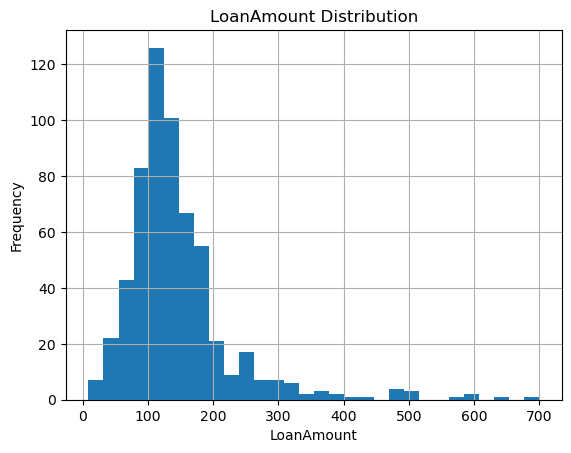

In [287]:
# Plot histogram for each feature
df['LoanAmount'].hist(bins=30)
plt.title('LoanAmount Distribution')
plt.xlabel('LoanAmount')
plt.ylabel('Frequency')
plt.show()

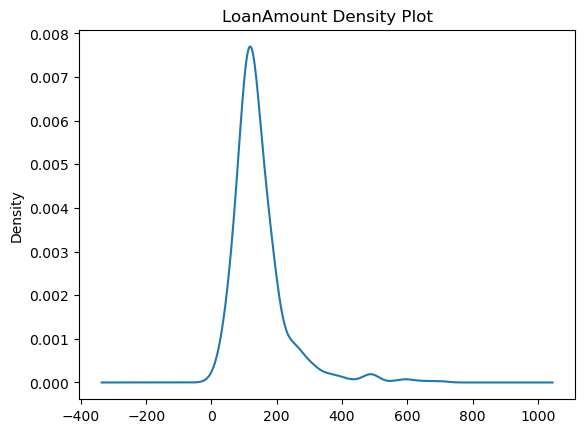

In [288]:
df['LoanAmount'].plot(kind='kde')
plt.title('LoanAmount Density Plot')
plt.show()
# NORMAL DISTRIBUTION USE STANDARD SCALAR

In [289]:
def preprocess_data(df, training=True):

    
    # Add missing value indicators only for columns with missing values
    for col in df.columns:
        if df[col].isnull().any():
            df[f'{col}_is_missing'] = df[col].isnull().astype(int)

    # Drop Loan_ID column if present
    if 'Loan_ID' in df.columns:
        df = df.drop(columns=['Loan_ID'])

    # Handle missing values
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:  # Numeric columns
            df[col] = df[col].fillna(df[col].median())
        elif df[col].dtype == 'object':  # Categorical columns
            df[col] = df[col].fillna(df[col].mode()[0])


    # Convert "3+" in Dependents to 3 and make column numeric
    if 'Dependents' in df.columns:
        df['Dependents'] = df['Dependents'].replace('3+', 3).astype(int)

    # Encode categorical variables
    # Turning value into number codes
    categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed']
    for col in categorical_columns:
        if col in df.columns:
            df[col] = pd.Categorical(df[col]).codes  # Convert categories to numeric codes

    #One-hot encode 'Property_Area' (if needed)
    # One hot encoding splits properta area values into their own columns so they can have binary values
    if 'Property_Area_Semiurban' in df.columns and 'Property_Area_Urban' in df.columns:
        pass
    else:
        if 'Property_Area' in df.columns:
            df = pd.get_dummies(df, columns=['Property_Area'], drop_first=True)

    # 7. Convert target column 'Loan_Status' to binary (if training)
    if training and 'Loan_Status' in df.columns:
        df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

    # 8. Remove target column for test data (if not training)
    if not training and 'Loan_Status' in df.columns:
        df = df.drop(columns=['Loan_Status'])

    return df

In [290]:
# INSPECT MISSING VALUES

df_train = preprocess_data(df)
df_train.head().T
# print(df.isnull().sum())


,0,1,2,3,4
Gender,1,1,1,1,1
Married,0,1,1,1,0
Dependents,0,1,0,0,0
Education,0,0,0,1,0
Self_Employed,0,0,1,0,0
ApplicantIncome,5849,4583,3000,2583,6000
CoapplicantIncome,0.0,1508.0,0.0,2358.0,0.0
LoanAmount,128.0,128.0,66.0,120.0,141.0
Loan_Amount_Term,360.0,360.0,360.0,360.0,360.0
Credit_History,1.0,1.0,1.0,1.0,1.0


In [302]:
X = df_train.drop(columns=['Loan_Status'])
y = df_train['Loan_Status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [303]:
print(X.shape, X_train.shape, X_val.shape)

(614, 19) (491, 19) (123, 19)


In [298]:
# Baseline: Predict the majority class
baseline_prediction = y_train.mode()[0]  # Most frequent target
baseline_accuracy = (y_train == baseline_prediction).mean()
print(f'Baseline Accuracy: {baseline_accuracy}')

Baseline Accuracy: 0.6965376782077393


In [301]:
from sklearn.preprocessing import StandardScaler

# Scale the training and testing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# print(X_train)
# Apply same scaling to validation set
X_val_scaled = scaler.transform(X_val)         

# Train Logistic Regression on scaled data
model = LinearSVC(random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = model.predict(X_val_scaled)  # Ensure scaled features are used
accuracy = accuracy_score(y_val, y_pred)
print(f'LinearSVC Accuracy (Scaled Data): {accuracy}')

LinearSVC Accuracy (Scaled Data): 0.7886178861788617
